In [2]:
import pandas as pd

## Read data

FMA repository is [here](https://github.com/mdeff/fma)

- Download the metadata file [here](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip) and unzip to `data-FMA` folder
- `tracks.csv` contains album, name, genre, and tags
- only a portion have complete tag information

## Read FMA tracks subset

In [3]:
filePath = "data-processed/tracks-tags.csv"
df = pd.read_csv(filePath, header=[0,1], index_col=0)
df.head()

artist            album                          track           \
                name            title                          title   genres   
track_id                                                                        
137           Airway     Live at LACE                         Side A  [1, 32]   
138           Airway     Live at LACE                         Side B  [1, 32]   
850       Human Host  Exploding Demon                Tomb Of Science     [12]   
851       Human Host  Exploding Demon                     Six Realms     [12]   
852       Human Host  Exploding Demon  Escape From the Organ Chamber     [12]   

                                      
           genres_all           tags  
track_id                              
137       [32, 1, 38]      ['lafms']  
138       [32, 1, 38]      ['lafms']  
850              [12]  ['baltimore']  
851              [12]  ['baltimore']  
852              [12]  ['baltimore']

## Replace or map genre codes with names

ref: pandas [replace](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html#pandas.DataFrame.replace) or [map](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html#pandas.DataFrame.map)

In [4]:
# Read in genres.csv
df_genres = pd.read_csv("data-FMA/genres.csv")
df_genres.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


Create a dictionary for mapping code in `tags genre` and `tags genre_all` to genre names

In [5]:
dict_map = {}

for index, row in df_genres.iterrows():
    dict_map[row["genre_id"]] = row["title"]

dict_map

{1: 'Avant-Garde',
 2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 6: 'Novelty',
 7: 'Comedy',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 11: 'Disco',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 16: 'Sound Effects',
 17: 'Folk',
 18: 'Soundtrack',
 19: 'Funk',
 20: 'Spoken',
 21: 'Hip-Hop',
 22: 'Audio Collage',
 25: 'Punk',
 26: 'Post-Rock',
 27: 'Lo-Fi',
 30: 'Field Recordings',
 31: 'Metal',
 32: 'Noise',
 33: 'Psych-Folk',
 36: 'Krautrock',
 37: 'Jazz: Vocal',
 38: 'Experimental',
 41: 'Electroacoustic',
 42: 'Ambient Electronic',
 43: 'Radio Art',
 45: 'Loud-Rock',
 46: 'Latin America',
 47: 'Drone',
 49: 'Free-Folk',
 53: 'Noise-Rock',
 58: 'Psych-Rock',
 63: 'Bluegrass',
 64: 'Electro-Punk',
 65: 'Radio',
 66: 'Indie-Rock',
 70: 'Industrial',
 71: 'No Wave',
 74: 'Free-Jazz',
 76: 'Experimental Pop',
 77: 'French',
 79: 'Reggae - Dub',
 81: 'Afrobeat',
 83: 'Nerdcore',
 85: 'Garage',
 86: 'Indian',
 88: 'New Wave',
 89: 'P

## Parse the cells in the track-tags column

ref: python [strings](https://docs.python.org/3/library/string.html#module-string) and the [re](https://docs.python.org/3/library/re.html#module-re) package

- practice re [here](https://regex101.com)

Create a dataframe with only track id and genre information:

Create function to split number string in genre column to individual substrings:

In [6]:
def split_numbers(input_string):
    # separate out just the numbers
    genre_code_list = input_string.strip("[]").split(",")
    # Map numbers in list to genre word (for..in)
    newList = [ ]

    for x in genre_code_list:
        # The original function was giving an error because of empty genre values in the dataframe
        #   e.g., int(x) cannot conver 'no value' to a number, so python gives an error
        #   The 'try--except' code in python lets you try to compute int(x), and if it give an error, 
        #           (see: https://pythonbasics.org/try-except/)
        #   then run some other code. So here, we try int(x), if it give an error, then return empty string
        try:
            r = dict_map[int(x)]   # r = the mapping at int(x)
        except ValueError:         # if int(x) fails with 'ValueError'
            r = ""                 # just make an empty string
        newList.append(r)
    return newList   # Return list for exploding later...
    #return ", ".join(newList)   # alternatively, rejoin into a string (so it fits in dataframe column)

# Test
# Input string
input_string = "[1, 5, 9, ]"

# Call the split_numbers function
result = split_numbers(input_string)

# Print the result
print(result)

['Avant-Garde', 'Classical', 'Country', '']


In [7]:
# Test pandas map()
data = {'column': ['[9, 10, 11]']}
df_test = pd.DataFrame(data)
df_test["column"].map(split_numbers)

0    [Country, Pop, Disco]
Name: column, dtype: object

Map the split numbers function to track id and genre dataframe:

**Note:** We will eventually want to analyzie the datafram with both tags and genre, so it makes sense to modify the columns int he original dataframe. 

The datafram isn't too big, see we can make a second copy (if you want to see the difference between origianl and modified.)

Since we have the map function written, we can run it on both genre columns.

In [8]:
df2 = df.copy() # use .copy() so df2 is actually separate from the original df (otherwise, 
                #    df2 acts like a 'link' to df, and changing df2 changes df as well :/)
df2[('track', 'genres')] = df2.loc[:, ('track', 'genres')].map(split_numbers)
df2[('track', 'genres_all')] = df2.loc[:, ('track', 'genres_all')].map(split_numbers)
df2[('track', 'tags')] = df2.loc[:, ('track', 'tags')].str.replace(r"\[|\]|'", "", regex=True).str.split(",") # clean up the tags
     #  Also, convert these values to a list for exploding later
df2.head()

artist            album                          track  \
                name            title                          title   
track_id                                                               
137           Airway     Live at LACE                         Side A   
138           Airway     Live at LACE                         Side B   
850       Human Host  Exploding Demon                Tomb Of Science   
851       Human Host  Exploding Demon                     Six Realms   
852       Human Host  Exploding Demon  Escape From the Organ Chamber   

                                                                    \
                        genres                          genres_all   
track_id                                                             
137       [Avant-Garde, Noise]  [Noise, Avant-Garde, Experimental]   
138       [Avant-Garde, Noise]  [Noise, Avant-Garde, Experimental]   
850                     [Rock]                              [Rock]   
851                     [Rock]                              [Rock]   
852                     [Rock]                              [Rock]   

                       
                 tags  
track_id               
137           [lafms]  
138           [lafms]  
850       [baltimore]  
851       [baltimore]  
852       [baltimore]

Create new dataframe with genre_word and track_id columns:

Group by genre words:

## Word frequency

### Tag (or genre) frequency

First filter by `track genres` then unnest tokens

pandas [Explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html) converts lists within a column to rows (kind of like wide to long based on a column list)

- we do this twice, separately, to unlist all of the genres and tags
- (verify this is correct?)

In [9]:
df2.explode(('track', 'genres')).explode(('track', 'tags')).tail()

artist                      album  \
                      name                      title   
track_id                                                
155320    Forget the Whale  What I Tell Myself Vol. 2   
155320    Forget the Whale  What I Tell Myself Vol. 2   
155320    Forget the Whale  What I Tell Myself Vol. 2   
155320    Forget the Whale  What I Tell Myself Vol. 2   
155320    Forget the Whale  What I Tell Myself Vol. 2   

                                              track              \
                                              title      genres   
track_id                                                          
155320    Another Trick Up My Sleeve (Instrumental)  Rockabilly   
155320    Another Trick Up My Sleeve (Instrumental)  Rockabilly   
155320    Another Trick Up My Sleeve (Instrumental)  Rockabilly   
155320    Another Trick Up My Sleeve (Instrumental)  Rockabilly   
155320    Another Trick Up My Sleeve (Instrumental)  Rockabilly   

                                                         
                                genres_all         tags  
track_id                                                 
155320    [Rockabilly, Pop, Rock, Country]    hard rock  
155320    [Rockabilly, Pop, Rock, Country]     cauldron  
155320    [Rockabilly, Pop, Rock, Country]      witches  
155320    [Rockabilly, Pop, Rock, Country]       creepy  
155320    [Rockabilly, Pop, Rock, Country]   black cats

Note: groupby() produces a dictionary where keys are the groups (genres) and values are the corresponing index of the main dataframe

In [10]:
groupby_genre = df2.explode(('track', 'genres')).explode(('track', 'tags')).groupby(('track', 'genres'))
len(groupby_genre) # 153 genre groups
# groupby_genre.groups # shows group keys and and row values

153

In [11]:
# this returns a dataframe
genre_tag_counts = df2.explode(('track', 'genres')).explode(('track', 'tags')).groupby([('track', 'genres'), ('track', 'tags')]).count()
genre_tag_counts.head()

artist album track           
                                       name title title genres_all
(track, genres) (track, tags)                                     
                 2013                    19    19    19         19
                 abstract                 1     1     1          1
                 abstract electronic      1     1     1          1
                 acoustic                 3     3     3          3
                 acoustic blues           1     1     1          1

The dataframe now has a multiindex index column, the first level being genre, the second level is tag, the values in the columns are the counts of each genre--tag combination

In [12]:
genre_tag_counts.index.get_level_values(0).unique() # see the unique level 0 index (genres)

Index(['', '20th Century Classical', 'Abstract Hip-Hop', 'African', 'Afrobeat',
       'Alternative Hip-Hop', 'Ambient', 'Ambient Electronic', 'Americana',
       'Asia-Far East',
       ...
       'Surf', 'Symphony', 'Synth Pop', 'Tango', 'Techno', 'Thrash',
       'Trip-Hop', 'Turkish', 'Unclassifiable', 'Wonky'],
      dtype='object', name=('track', 'genres'), length=153)

In [13]:
genre_tag_counts.index.get_level_values(1).unique() # see the unique level 1 index (tags)

Index([' 2013', ' abstract', ' abstract electronic', ' acoustic',
       ' acoustic blues', ' acustronica', ' adventure', ' aerial',
       ' allentown', ' alternative',
       ...
       ' the craters', '80s', 'earth-enemy', 'human resources',
       'monroeville music center', 'tango', ' cellar dweller',
       ' sheffield techno', 'planet terror records', 'techstep'],
      dtype='object', name=('track', 'tags'), length=5708)

## Analyze by genre

In [14]:
genre_tag_counts.loc["Classical"] # This will select all in index with single genre

artist album track           
                            name title title genres_all
(track, tags)                                          
 20th century composition     29    29    29         29
 21st century composition     16    16    16         16
 45 echoes sounds              3     3     3          3
 abstract                     15    15    15         15
 absurd                        3     3     3          3
...                          ...   ...   ...        ...
tosti                         20    20    20         20
tracks to sync                38    38    38         38
wall matthews                  8     8     8          8
weber                         23    23    23         23
wmfu                           3     3     3          3

[549 rows x 4 columns]

## Analyze by tag

In [15]:
genre_tag_counts.xs("abstract", level=1) # slightly different method of selection
# retruns all genres that use the 'ambiant tag'

artist album track           
                   name title title genres_all
(track, genres)                               
Ambient               9     9     9          9
Avant-Garde          29    29    29         29
Drone                 9     9     9          9
Electroacoustic      14    14    14         14
Electronic            4     4     4          4
Experimental         33    33    33         33
Field Recordings      9     9     9          9
Free-Jazz            15    15    15         15
IDM                   4     4     4          4
Instrumental          4     4     4          4
Jazz                 15    15    15         15
Musique Concrete     14    14    14         14

## Plotting results

Try [matplotlib](https://matplotlib.org/stable/plot_types/index.html) or [seaborn](https://seaborn.pydata.org/examples/index.html) or [plotly](https://plotly.com/python/)...?

- install with conda if needed

In [16]:
import matplotlib.pyplot as plt

<Axes: xlabel='(track, tags)'>

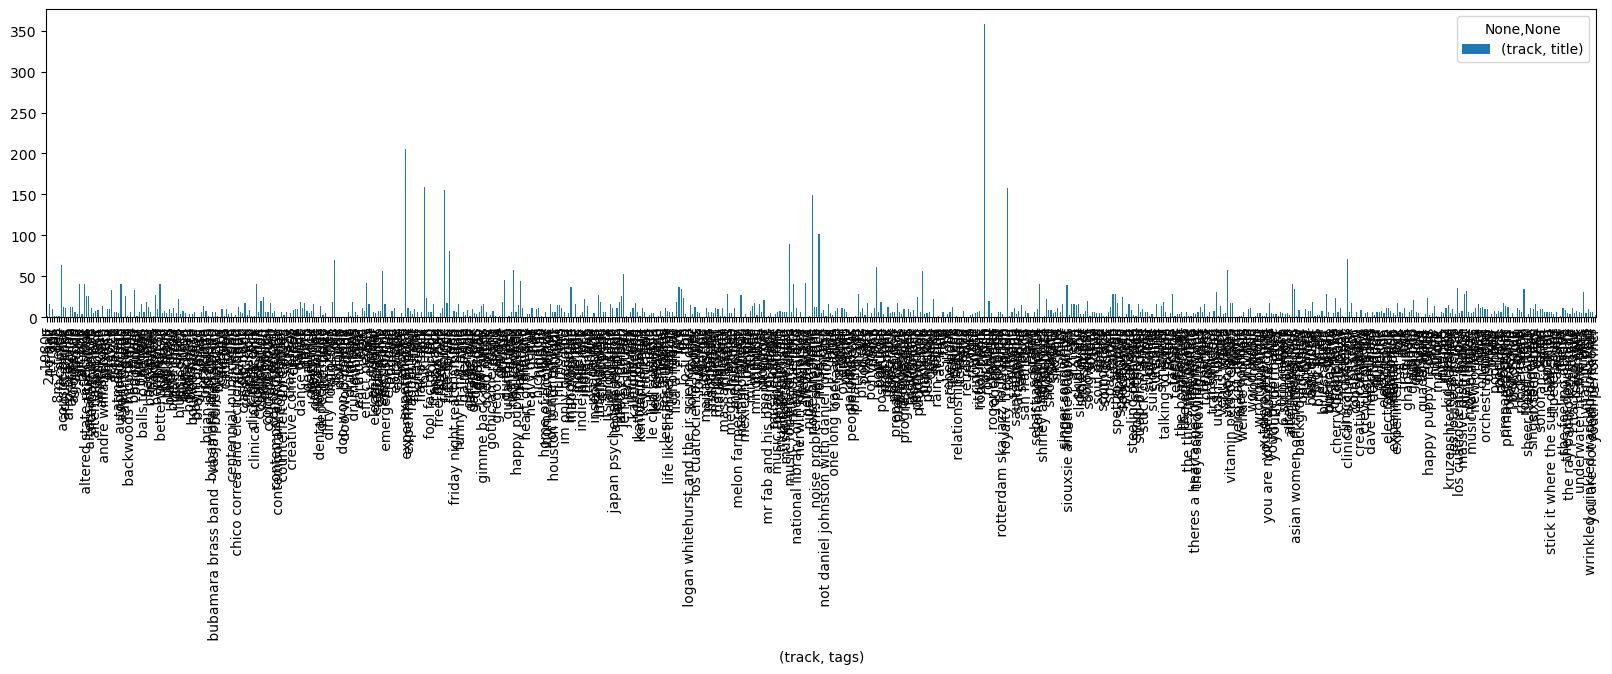

In [17]:
genre_tag_counts.xs("Rock", level=0).plot.bar(y=('track', 'title'), figsize=(20, 4))

This is difficult to read, maybe just pick the top tags...

<Axes: xlabel='(track, tags)'>

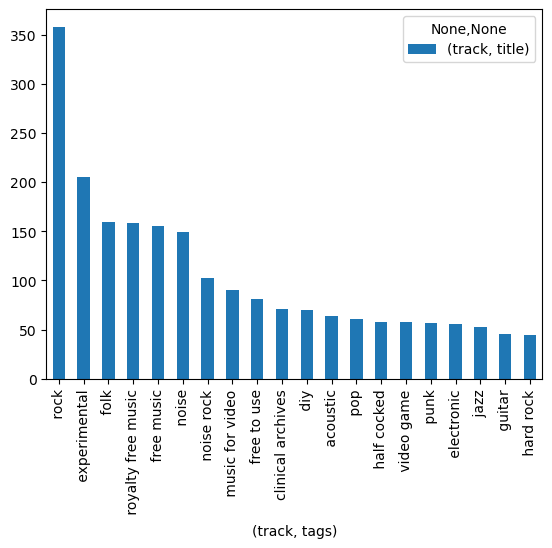

In [18]:
(genre_tag_counts
 .xs("Rock", level=0)
 .nlargest(20, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, genres)'>

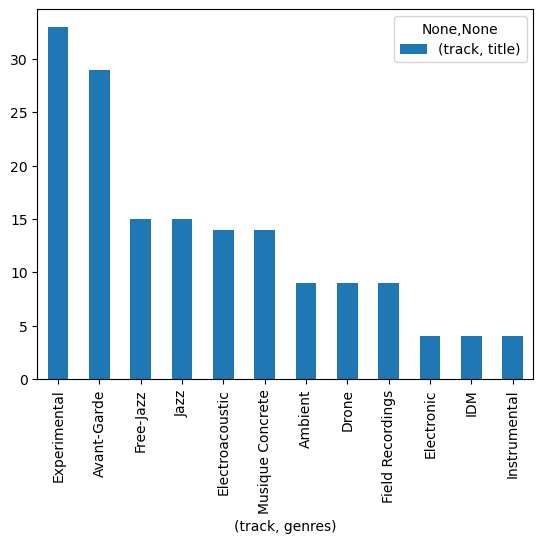

In [19]:
(genre_tag_counts
 .xs("abstract", level=1)
 .sort_values(by=('track', 'title'), ascending=False)
 .plot.bar(y=('track', 'title')))

Selected 10 Genres for inclusion: Rock, Electronic, Hip-hop, Folk, Pop, Classical, Jazz, Country, Soul-RnB, Blues

<Axes: xlabel='(track, tags)'>

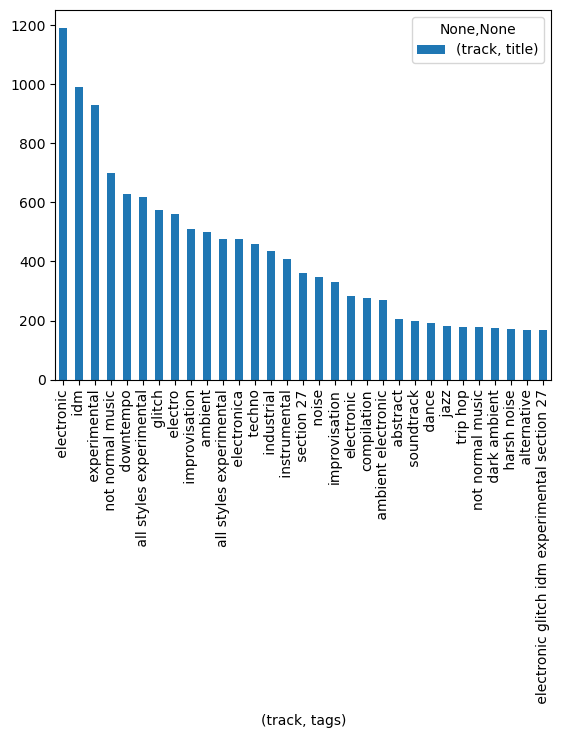

In [26]:
(genre_tag_counts
 .xs("Electronic", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

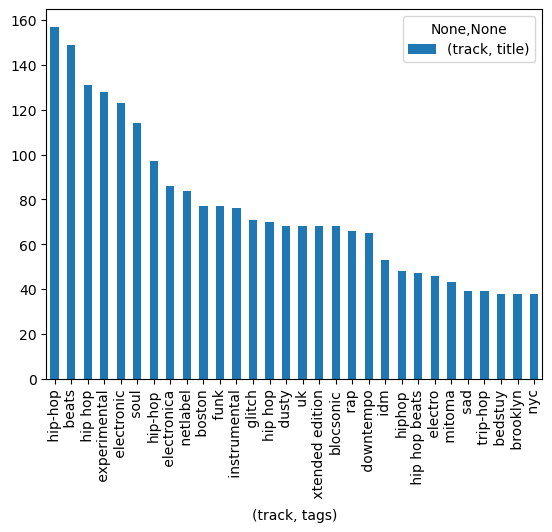

In [27]:
(genre_tag_counts
 .xs("Hip-Hop", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

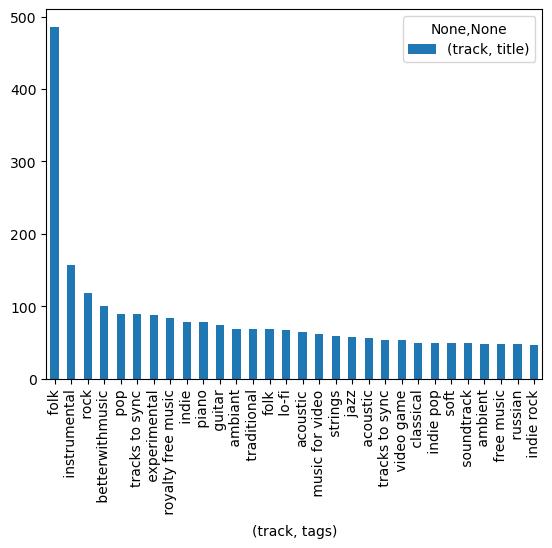

In [28]:
(genre_tag_counts
 .xs("Folk", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

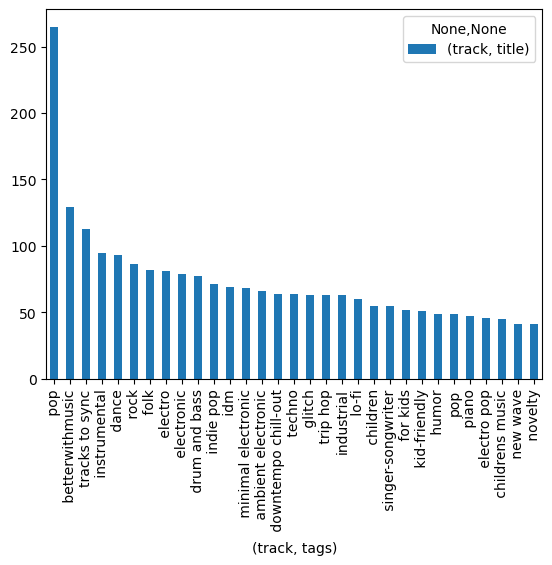

In [30]:
(genre_tag_counts
 .xs("Pop", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

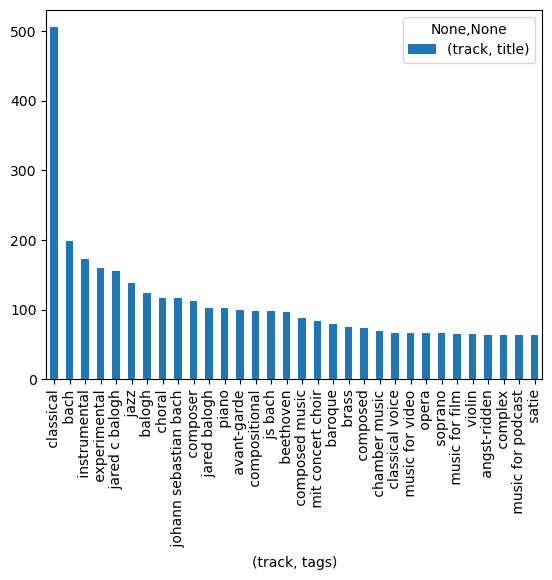

In [31]:
(genre_tag_counts
 .xs("Classical", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

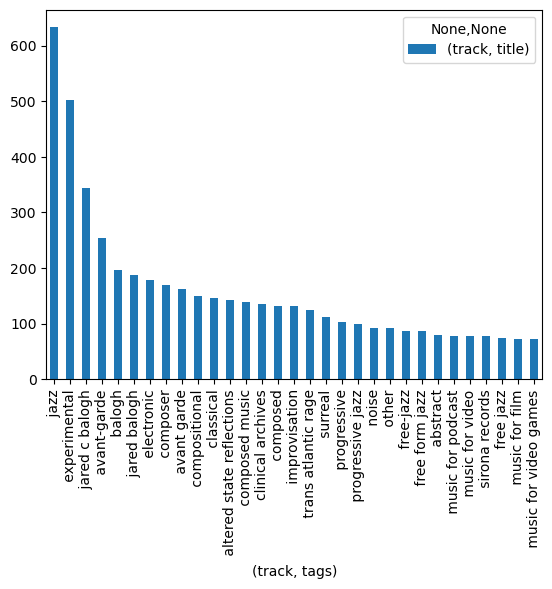

In [32]:
(genre_tag_counts
 .xs("Jazz", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

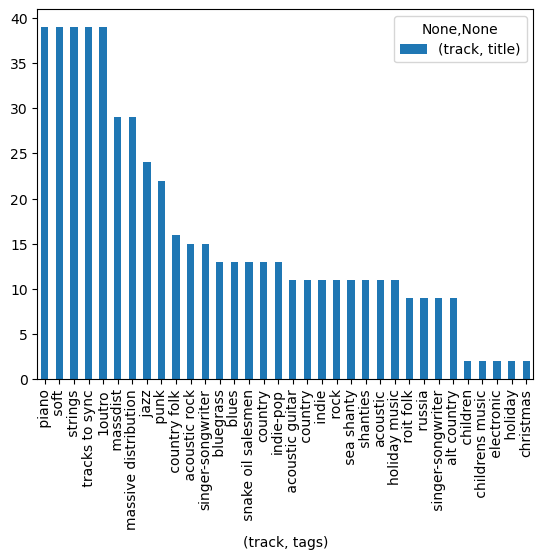

In [39]:
(genre_tag_counts
 .xs("Country", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

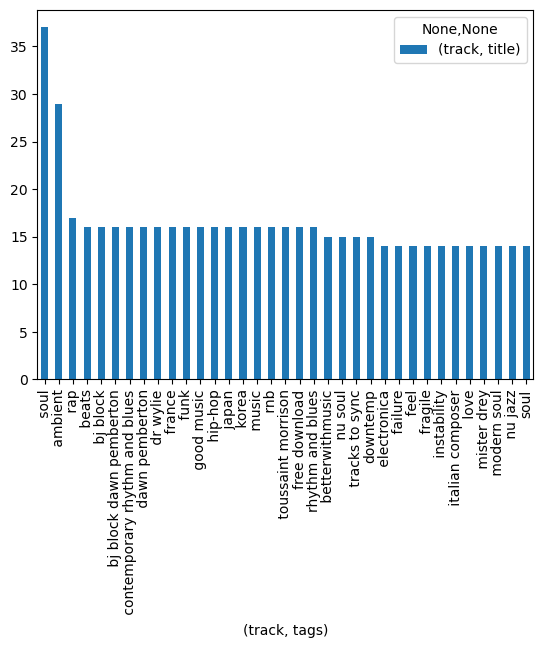

In [35]:
(genre_tag_counts
 .xs("Soul-RnB", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

<Axes: xlabel='(track, tags)'>

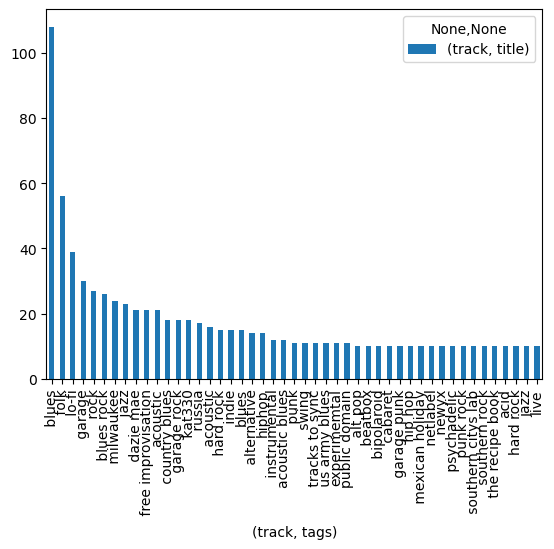

In [36]:
(genre_tag_counts
 .xs("Blues", level=0)
 .nlargest(30, ('track', 'title'), keep="all")
 .plot.bar(y=('track', 'title')))

In [42]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cath\AppData\Roaming\nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora\stopwords.zip.


In [43]:
psychological_attributes = ['Intense', 'Tense', 'Forceful', 'Aggressive', 'Angry', 'Abrasive', 'Strong', 'Mellow', 'Thrilling', 'Gentle', 'Manic', 'Calming', 'Warm', 'Reflective', 'Relaxing', 'Romantic', 'Sensual', 'Happy', 'Fun', 'Depressing', 'Merry', 'Joyful', 'Enthusiastic', 'Lively', 'Animated', 'Amusing', 'Sad', 'Intelligent', 'Sophisticated', 'Inspiring', 'Complex', 'Poetic', 'Deep', 'Dreamy', 'Thoughtful', 'Party Music', 'Emotional', 'Danceable']

In [44]:
print(psychological_attributes)

['Intense', 'Tense', 'Forceful', 'Aggressive', 'Angry', 'Abrasive', 'Strong', 'Mellow', 'Thrilling', 'Gentle', 'Manic', 'Calming', 'Warm', 'Reflective', 'Relaxing', 'Romantic', 'Sensual', 'Happy', 'Fun', 'Depressing', 'Merry', 'Joyful', 'Enthusiastic', 'Lively', 'Animated', 'Amusing', 'Sad', 'Intelligent', 'Sophisticated', 'Inspiring', 'Complex', 'Poetic', 'Deep', 'Dreamy', 'Thoughtful', 'Party Music', 'Emotional', 'Danceable']


## TODO:

We haven't excluded irrelevant tags yet, or selected genres of interest.

- think about genres we are interested in?
- what tags are we interested in (some in the present analysis aren't relevant)

Are these plots good? Should we try something different?


## Hypotheses/Questions

Now that we can do the analysis, what questions do you have? Hypotheses?

### TODO: Statistics...

## Original anlaysis

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

In [ ]:
df_genre_words.dtypes

In [ ]:
df_genre_words.apply(word_tokenize)
df_genre_words['genrewords'] = df_genre_words[("track", "genres")].apply(word_tokenize)

In [ ]:
df_track_genres[("track", "genres")].apply(word_tokenize)

df_track_genres['genrewords'] = df_track_genres[("track", "genres")].apply(word_tokenize)

df_track_genres